# Text Classification Model for IMDB Movie Sentiment Using TensorFlow Take 1 Part A
### David Lowe
### March 26, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a text classification model using a neural network and document the end-to-end steps using a template. The IMDB Movie Sentiment dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset contains 50,000 movie reviews extracted from IMDB. The researchers have annotated the tweets with labels (0 = negative, 1 = positive) to detect the reviews' sentiment.

In this Take1 iteration, we will create a bag-of-words model to perform binary classification (positive or negative) for the Tweets. The Part A script will focus on building the model with the training and validation datasets due to memory capacity constraints. Part B will focus on testing the model with the training and test datasets.

ANALYSIS: In this Take1 iteration, the preliminary model's performance achieved an accuracy score of 88.80% on the validation dataset after 10 epochs. Furthermore, the final model processed the test dataset with an accuracy measurement of 89.48%.

CONCLUSION: In this iteration, the bag-of-words TensorFlow model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: IMDB Movie Sentiment

Dataset ML Model: Binary class text classification with text-oriented features

Dataset Reference: https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format

One potential source of performance benchmarks: https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format

A deep-learning text classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Text Data
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import shutil
import string
import nltk
# import boto3
# from dotenv import load_dotenv
from nltk.corpus import stopwords
from collections import Counter
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [7]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/pythonml/nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the verbose level for program execution output
verbose = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=seedNum)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCH = 10
BATCH_SIZE = 64
MIN_OCCURANCE = 2
NUM_CLASSES = 1
ENCODING_MODE = 'tfidf'

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.1


In [9]:
# Set up the parent directory location for loading the dotenv files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Text Data

In [14]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 2 - Load and Prepare Text Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 2.a) Download Text Data Archive

In [15]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-imdb-movie-sentiment/Train.csv'
Xy_train = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
print(Xy_train.info())
print(Xy_train.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1


In [16]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-imdb-movie-sentiment/Valid.csv'
Xy_valid = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
print(Xy_valid.info())
print(Xy_valid.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None
                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0
5  This is the best movie I've ever seen! <br /><...      1
6  The morbid Catholic writer Gerard Reve (Jeroen...      1
7  "Semana Santa" or "Angel Of Death" is a very w...      0
8  Somebody mastered the difficult task of mergin...      1
9  Why did I waste 1.5 hours of my life watching ...      0


## 2.b) Splitting Data into Feature and Label Sets

In [17]:
X_train_df = Xy_train.iloc[:,0]
y_train_df = Xy_train.iloc[:,1]
print('X_train_df.shape: {} y_train_df.shape: {}'.format(X_train_df.shape, y_train_df.shape))

X_train_df.shape: (40000,) y_train_df.shape: (40000,)


In [18]:
X_valid_df = Xy_valid.iloc[:,0]
y_valid_df = Xy_valid.iloc[:,1]
print('X_valid_df.shape: {} y_valid_df.shape: {}'.format(X_valid_df.shape, y_valid_df.shape))

X_valid_df.shape: (5000,) y_valid_df.shape: (5000,)


In [19]:
X_complete_df = pd.concat([X_train_df, X_valid_df], ignore_index=True)
y_complete_df = pd.concat([y_train_df, y_valid_df], ignore_index=True)
print('X_complete_df.shape: {} y_complete_df.shape: {}'.format(X_complete_df.shape, y_complete_df.shape))

X_complete_df.shape: (45000,) y_complete_df.shape: (45000,)


## 2.c) Load Document and Build Vocabulary

In [20]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [21]:
# load sentences and add to vocab
def add_sentence_to_vocab(sentence, vocab):
    # clean doc
    tokens = clean_sentence(sentence)
    # update counts
    vocab.update(tokens)

In [22]:
# load all sentences in the dataframe
def build_vocabulary(comments, vocab):
    # walk through all comments in the dataframe
    for i in range(len(comments)):
        # add comments to vocab
        sentence = comments.iloc[i]
        add_sentence_to_vocab(sentence, vocab)
        if verbose : print('Processing comment:', sentence)
        if ((i+1) % 100000) == 0 : print(i+1, 'comments processed so far.')
    print('Total number of comments loaded into the vocabulary:', i+1, '\n')

In [23]:
# define vocab
vocab = Counter()
# add all docs to vocab
build_vocabulary(X_complete_df, vocab)
# print the size of the vocab
print('The total number of words in the vocabulary:', len(vocab))
# print the top words in the vocab
top_words = 50
print('The top', top_words, 'words in the vocabulary:\n', vocab.most_common(top_words))

Total number of comments loaded into the vocabulary: 45000 

The total number of words in the vocabulary: 195713
The top 50 words in the vocabulary:
 [('br', 102476), ('The', 79702), ('movie', 74201), ('film', 65917), ('one', 41670), ('like', 33799), ('This', 26243), ('good', 24690), ('It', 21382), ('would', 21355), ('time', 20444), ('really', 20025), ('see', 19639), ('even', 19348), ('story', 19257), ('much', 16539), ('get', 16019), ('people', 15037), ('bad', 14970), ('great', 14847), ('well', 14162), ('first', 13793), ('also', 13724), ('make', 13676), ('made', 13654), ('movies', 13619), ('films', 13560), ('could', 13413), ('way', 13161), ('dont', 13047), ('characters', 12999), ('But', 12592), ('think', 12516), ('And', 11900), ('Its', 11823), ('seen', 11695), ('character', 11505), ('watch', 11271), ('many', 11235), ('never', 10931), ('acting', 10908), ('know', 10907), ('plot', 10833), ('two', 10802), ('In', 10515), ('little', 10469), ('love', 10403), ('show', 10341), ('best', 10190), 

In [24]:
# keep tokens with a min occurrence in the vocabulary
tokens = [k for k,c in vocab.items() if c >= MIN_OCCURANCE]
print('The number of words with the minimum appearance:', len(tokens))

The number of words with the minimum appearance: 89668


In [25]:
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocabulary.txt')

## 2.d) Create Tokenizer and Encode the Input Text

In [26]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [27]:
# load the vocabulary
vocab_filename = 'vocabulary.txt'
vocab_text = load_doc(vocab_filename)
vocab_words = vocab_text.split()
vocab = set(vocab_words)
print('Number of tokens in the vocabulary:', len(vocab))

Number of tokens in the vocabulary: 89668


In [28]:
# load comments, clean and return line of tokens
def comment_to_line(sentence, vocab):
    # clean sentence
    tokens = clean_sentence(sentence)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    return line

In [29]:
# load all comments in a directory
def process_comments_to_lines(comments, vocab):
    lines = list()
    # walk through all comments in the dataframe
    for i in range(len(comments)):
        # load and clean the comments
        sentence = comments.iloc[i]
        line = comment_to_line(sentence, vocab)
        # add to list
        lines.append(line)
    return lines

In [30]:
# Load all training cases
train_docs = process_comments_to_lines(X_train_df, vocab)
print('Number of comments processed:', len(train_docs))

Number of comments processed: 40000


In [31]:
# Load all validation cases
valid_docs = process_comments_to_lines(X_valid_df, vocab)
print('Number of comments processed:', len(valid_docs))

Number of comments processed: 5000


In [32]:
# prepare bag-of-words encoding of training dataset
def encode_train_data(docs_set, mode=ENCODING_MODE):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(docs_set)
    # encode training data set
    train_encoded = tokenizer.texts_to_matrix(docs_set, mode=mode)
    return train_encoded, tokenizer

In [33]:
# prepare bag-of-words encoding of validation datasets
def encode_valid_data(docs_set, tokenizer, mode=ENCODING_MODE):
    # encode test data set
    valid_encoded = tokenizer.texts_to_matrix(docs_set, mode=mode)
    return valid_encoded

In [34]:
# Encode the training dataset
X_train, trained_tokenizer = encode_train_data(train_docs)
print('The shape of the encoded training dataset:', X_train.shape)

The shape of the encoded training dataset: (40000, 73083)


In [35]:
y_train = y_train_df.values.ravel()
print('The shape of the encoded training classes:', y_train.shape)

The shape of the encoded training classes: (40000,)


In [36]:
# Encode the validation dataset
X_valid = encode_valid_data(valid_docs, trained_tokenizer)
print('The shape of the encoded validation dataset:', X_valid.shape)

The shape of the encoded validation dataset: (5000, 73083)


In [37]:
y_valid = y_valid_df.values.ravel()
print('The shape of the encoded validation classes:', y_train.shape)

The shape of the encoded validation classes: (40000,)


In [38]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 2 - Load and Prepare Text Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [39]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=X_train.shape[1], output_param=NUM_CLASSES, layer1_nodes=64, opt_param=DEFAULT_OPTIMIZER):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=DEFAULT_INITIALIZER),
        keras.layers.Dense(output_param, activation=CLASSIFIER_ACTIVATION, kernel_initializer=DEFAULT_INITIALIZER)
    ])
    nn_model.compile(loss=DEFAULT_LOSS, optimizer=opt_param, metrics=DEFAULT_METRICS)
    return nn_model

In [41]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCH,
	validation_data=(X_valid, y_valid),
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/10
625/625 [==============================] - 26s 42ms/step - loss: 0.3270 - accuracy: 0.8625 - val_loss: 0.2713 - val_accuracy: 0.8912
Epoch 2/10
625/625 [==============================] - 23s 37ms/step - loss: 0.0588 - accuracy: 0.9811 - val_loss: 0.3445 - val_accuracy: 0.8878
Epoch 3/10
625/625 [==============================] - 23s 37ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.4480 - val_accuracy: 0.8880
Epoch 4/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.5209 - val_accuracy: 0.8864
Epoch 5/10
625/625 [==============================] - 24s 38ms/step - loss: 8.1720e-04 - accuracy: 1.0000 - val_loss: 0.5776 - val_accuracy: 0.8880
Epoch 6/10
625/625 [==============================] - 24s 38ms/step - loss: 4.2918e-04 - accuracy: 1.0000 - val_loss: 0.6216 - val_accuracy: 0.8878
Epoch 7/10
625/625 [==============================] - 23s 37ms/step - loss: 2.5668e-04 - accuracy: 1.0000 - val_loss: 0.6592 - v

In [42]:
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

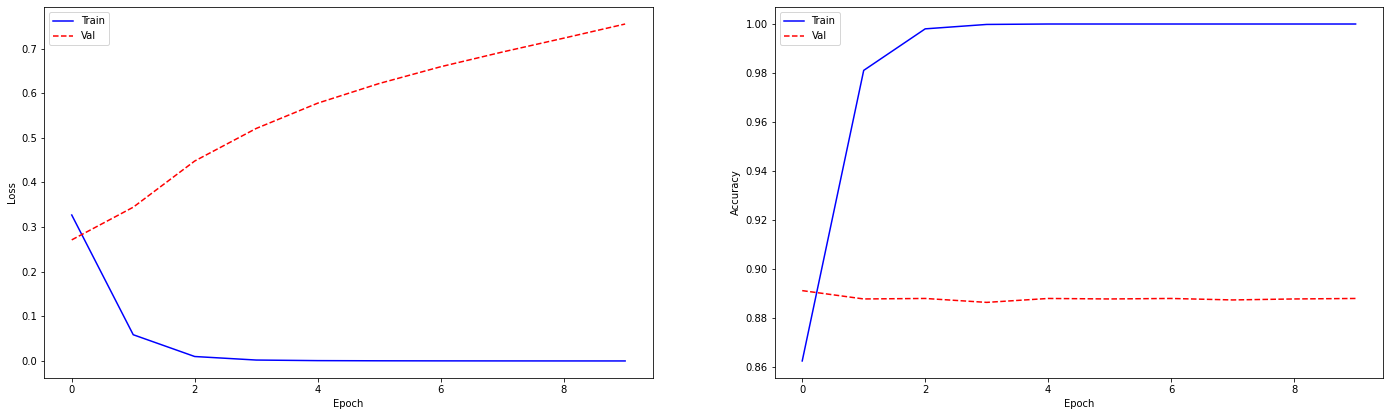

In [43]:
plot_metrics(baseline_model_history)

In [44]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [45]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [46]:
# Not applicable for this iteration of modeling

In [47]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [48]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 5.a) Train the Final Model

In [49]:
# # Load all training cases
# complete_docs = process_comments_to_lines(X_complete_df, vocab)
# print('Number of comments processed:', len(complete_docs))

In [50]:
# # Encode the training dataset
# X_complete, final_tokenizer = encode_train_data(complete_docs)
# print('The shape of the encoded final dataset:', X_complete.shape)

In [51]:
# y_complete = y_complete_df.values.ravel()
# print('The shape of the encoded training classes:', y_complete.shape)

In [52]:
# # Define the baseline model for benchmarking
# def create_nn_model(input_param=X_complete.shape[1], output_param=NUM_CLASSES, layer1_nodes=64, opt_param=DEFAULT_OPTIMIZER):
#     nn_model = keras.Sequential([
#         keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=DEFAULT_INITIALIZER),
#         keras.layers.Dense(output_param, activation=CLASSIFIER_ACTIVATION, kernel_initializer=DEFAULT_INITIALIZER)
#     ])
#     nn_model.compile(loss=DEFAULT_LOSS, optimizer=opt_param, metrics=DEFAULT_METRICS)
#     return nn_model

In [53]:
# # Create the final model for evaluating the test dataset
# FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
# reset_random(seedNum)
# final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
# final_model.fit(X_complete, y_complete, epochs=MAX_EPOCH, batch_size=BATCH_SIZE, verbose=1)

In [54]:
# # Summarize the final model
# final_model.summary()

## 5.b) Load Test Dataset and Make Predictions

In [55]:
# dataset_path = 'https://dainesanalytics.com/datasets/kaggle-imdb-movie-sentiment/Test.csv'
# Xy_test = pd.read_csv(dataset_path)

# # Take a peek at the dataframe after import
# print(Xy_test.info())
# print(Xy_test.head(10))

In [56]:
# X_test_df = Xy_test.iloc[:,0]
# y_test_df = Xy_test.iloc[:,1]
# print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

In [57]:
# # Load all test cases
# test_docs = process_comments_to_lines(X_test_df, vocab)
# print('Number of comments processed:', len(test_docs))

In [58]:
# # prepare bag-of-words encoding of test datasets
# def encode_test_data(docs_set, tokenizer, mode='tfidf'):
#     # encode test data set
#     test_encoded = tokenizer.texts_to_matrix(docs_set, mode=mode)
#     return test_encoded

In [59]:
# # Encode the validation dataset
# X_test = encode_test_data(test_docs, final_tokenizer)
# print('The shape of the encoded test dataset:', X_test.shape)

In [60]:
# y_test = y_test_df.values.ravel()
# print('The shape of the encoded testing classes:', y_test.shape)

In [61]:
# # test_predictions = final_model.predict(X_test, batch_size=default_batch, verbose=1)
# test_predictions = (final_model.predict(X_test) > 0.5).astype("int32").ravel()
# print('Accuracy Score:', accuracy_score(y_test, test_predictions))
# print(confusion_matrix(y_test, test_predictions))
# print(classification_report(y_test, test_predictions))

In [62]:
if notifyStatus: status_notify('(TensorFlow Text Classification) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [63]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:10:28.425832
